In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
sns.set_style("white")
%matplotlib inline

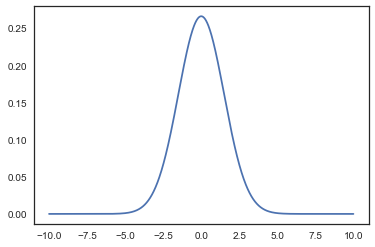

In [4]:
x = np.linspace(start = -10, stop = 10, num = 1000)
y = stats.norm.pdf(x, loc = 0, scale = 1.5)
plt.plot(x,y)

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("data/bimodal_example.csv")
df.head(n = 5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


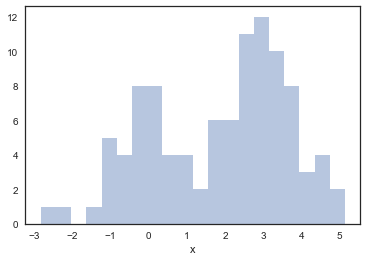

In [8]:
data = df.x
sns.distplot(data, bins = 20, kde = False)

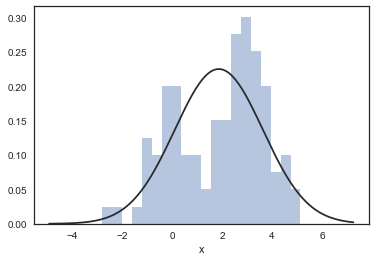

In [9]:
sns.distplot(data, fit = stats.norm, bins = 20, kde = False)

In [10]:
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def pdf(self, datum):
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self,):
        return "Gaussian({0:4.6}, {1:4.6})".format(self.mu, self.sigma)

In [12]:
best_single = Gaussian(np.mean(data), np.std(data))
print("Best Single Gaussian: mu = {:.2}, sigma = {:.2}".format(best_single.mu, best_single.sigma))

Best Single Gaussian: mu = 1.9, sigma = 1.8


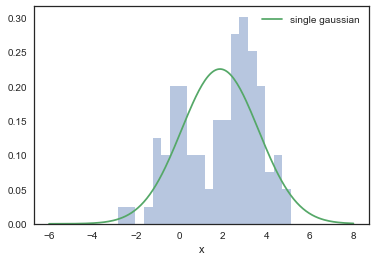

In [13]:
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins = 20, kde = False, norm_hist = True)
plt.plot(x, g_single, label = 'single gaussian')
plt.legend()

In [14]:
from math import sqrt, log, exp, pi
from random import uniform

In [15]:
class GaussianMixture:
    def __init__(self, data, mu_min = min(data), mu_max = max(data), sigma_min = 0.1, sigma_max = 1, mix = 0.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        self.mix = mix
    
    def EStep(self):
        self.loglikelihood = 0
        for datum in self.data:
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1 - self.mix)
            
            den = wp1 + wp2
            wp1 /= den
            wp2 /= den
            
            self.loglikelihood += log(wp1 + wp2)
            
            yield (wp1, wp2)
    
    def MStep(self, weights):
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, left))
        
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2) for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2) for (w, d) in zip(right, data)) / two_den)
        
        self.mix = one_den / len(data)
        
    def iterate(self, N = 1, verbose = False):
        for i in range(1, N+1):
            self.MStep(self.EStep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.EStep()
    
    def pdf(self, x):
        return (self.mix) * self.one.pdf(x) + (1 - self.mix) * self.two.pdf(x)
    
    def __repr__(self):
        return "Gaussian Mixture({0}, {1}, mix = {2.03})".format(self.one, self.two, self.mix)
    
    def __str__(self):
        return "Mixture({0}, {1}, mix = {2:.03})".format(self.one, self.two, self.mix)
    

In [21]:
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        mix.iterate(verbose = True)
        if mix.loglikelihood > best_loglike:
            best_loglike = mix.loglikelihood
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning):
        pass

 1 Mixture(Gaussian(1.43029, 1.58522), Gaussian(0.0686658, 4.09829), mix = 0.84)
 1 Mixture(Gaussian(1.89862, 1.67991), Gaussian(0.824638, 2.4462), mix = 0.882)
 1 Mixture(Gaussian(1.97682, 1.69261), Gaussian(0.835324, 2.08799), mix = 0.888)
 1 Mixture(Gaussian(1.99519, 1.69851), Gaussian(0.834126, 1.96691), mix = 0.887)
 1 Mixture(Gaussian(2.00201, 1.70143), Gaussian(0.832818, 1.91663), mix = 0.886)


In [33]:
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts..\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate(verbose = True)
            if mix.loglikelihood > best_loglike:
                best_loglike = mix.loglikelihood
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning):
            pass
print("\n\nDone")

Computing best model with random restarts..

 1 Mixture(Gaussian(2.43394, 1.87706), Gaussian(0.0796486, 1.15477), mix = 0.644)
 1 Mixture(Gaussian(2.55976, 1.4451), Gaussian(0.409261, 1.24657), mix = 0.716)
 1 Mixture(Gaussian(2.61693, 1.35213), Gaussian(0.381086, 1.33899), mix = 0.702)
 1 Mixture(Gaussian(2.69159, 1.27607), Gaussian(0.339474, 1.34964), mix = 0.68)
 1 Mixture(Gaussian(2.78173, 1.19012), Gaussian(0.288952, 1.31487), mix = 0.658)
 1 Mixture(Gaussian(2.87886, 1.09018), Gaussian(0.232986, 1.25508), mix = 0.637)
 1 Mixture(Gaussian(2.96736, 0.989522), Gaussian(0.179316, 1.18627), mix = 0.621)
 1 Mixture(Gaussian(3.03075, 0.912006), Gaussian(0.137482, 1.12657), mix = 0.61)
 1 Mixture(Gaussian(3.06533, 0.868573), Gaussian(0.111679, 1.08776), mix = 0.605)
 1 Mixture(Gaussian(3.08019, 0.849579), Gaussian(0.0986607, 1.06757), mix = 0.603)
 1 Mixture(Gaussian(3.08543, 0.842432), Gaussian(0.0929159, 1.05803), mix = 0.602)
 1 Mixture(Gaussian(3.08691, 0.840023), Gaussian(0.0905249,

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


 1 Mixture(Gaussian(3.08843, 0.838345), Gaussian(0.0895118, 1.0525), mix = 0.602)
 1 Mixture(Gaussian(3.0877, 0.838691), Gaussian(0.0891603, 1.05095), mix = 0.602)
 1 Mixture(Gaussian(3.08722, 0.838948), Gaussian(0.0889721, 1.05002), mix = 0.603)
 1 Mixture(Gaussian(3.0869, 0.839124), Gaussian(0.0888671, 1.04946), mix = 0.603)
 1 Mixture(Gaussian(2.5367, 1.33912), Gaussian(0.27305, 1.1066), mix = 0.779)
 1 Mixture(Gaussian(2.604, 1.32824), Gaussian(0.340234, 1.22315), mix = 0.734)
 1 Mixture(Gaussian(2.67998, 1.27493), Gaussian(0.322074, 1.27003), mix = 0.699)
 1 Mixture(Gaussian(2.77008, 1.19516), Gaussian(0.280491, 1.26452), mix = 0.67)
 1 Mixture(Gaussian(2.86765, 1.09729), Gaussian(0.22879, 1.22438), mix = 0.646)
 1 Mixture(Gaussian(2.95776, 0.996598), Gaussian(0.177315, 1.16816), mix = 0.626)
 1 Mixture(Gaussian(3.02367, 0.917362), Gaussian(0.13647, 1.11604), mix = 0.614)
 1 Mixture(Gaussian(3.06071, 0.871886), Gaussian(0.111048, 1.08144), mix = 0.607)
 1 Mixture(Gaussian(3.07736,

 1 Mixture(Gaussian(1.87719, 1.91631), Gaussian(0.51778, 2.06803), mix = 0.536)
 1 Mixture(Gaussian(2.27632, 1.60565), Gaussian(0.540827, 1.96824), mix = 0.587)
 1 Mixture(Gaussian(2.44693, 1.47128), Gaussian(0.504675, 1.84513), mix = 0.621)
 1 Mixture(Gaussian(2.55752, 1.38644), Gaussian(0.454794, 1.72259), mix = 0.636)
 1 Mixture(Gaussian(2.65264, 1.31144), Gaussian(0.400179, 1.60893), mix = 0.638)
 1 Mixture(Gaussian(2.74841, 1.22902), Gaussian(0.341603, 1.50146), mix = 0.633)
 1 Mixture(Gaussian(2.84776, 1.13296), Gaussian(0.279449, 1.39548), mix = 0.623)
 1 Mixture(Gaussian(2.94277, 1.02919), Gaussian(0.217717, 1.29141), mix = 0.612)
 1 Mixture(Gaussian(3.01781, 0.938247), Gaussian(0.164746, 1.19903), mix = 0.604)
 1 Mixture(Gaussian(3.06275, 0.879966), Gaussian(0.127888, 1.13186), mix = 0.6)
 1 Mixture(Gaussian(3.08264, 0.852447), Gaussian(0.107099, 1.09248), mix = 0.599)
 1 Mixture(Gaussian(3.08896, 0.842084), Gaussian(0.0970673, 1.07203), mix = 0.599)
 1 Mixture(Gaussian(3.0899

 1 Mixture(Gaussian(3.10773, 0.828251), Gaussian(0.0967697, 1.0898), mix = 0.591)
 1 Mixture(Gaussian(3.10021, 0.831911), Gaussian(0.0935324, 1.074), mix = 0.596)
 1 Mixture(Gaussian(3.09521, 0.83449), Gaussian(0.0915814, 1.06419), mix = 0.599)
 1 Mixture(Gaussian(3.09196, 0.836244), Gaussian(0.090422, 1.05815), mix = 0.6)
 1 Mixture(Gaussian(3.08987, 0.837405), Gaussian(0.0897358, 1.05444), mix = 0.601)
 1 Mixture(Gaussian(3.08855, 0.838156), Gaussian(0.0893288, 1.05217), mix = 0.602)
 1 Mixture(Gaussian(3.08772, 0.838635), Gaussian(0.0890862, 1.05079), mix = 0.602)
 1 Mixture(Gaussian(3.08721, 0.838937), Gaussian(0.0889408, 1.04994), mix = 0.603)
 1 Mixture(Gaussian(3.08689, 0.839125), Gaussian(0.0888532, 1.04942), mix = 0.603)
 1 Mixture(Gaussian(3.08669, 0.839242), Gaussian(0.0888001, 1.0491), mix = 0.603)
 1 Mixture(Gaussian(3.08657, 0.839315), Gaussian(0.0887678, 1.0489), mix = 0.603)
 1 Mixture(Gaussian(3.0865, 0.83936), Gaussian(0.0887482, 1.04879), mix = 0.603)
 1 Mixture(Gaus

 1 Mixture(Gaussian(2.4341, 1.46909), Gaussian(0.517343, 1.67347), mix = 0.707)
 1 Mixture(Gaussian(2.49097, 1.43163), Gaussian(0.481951, 1.62045), mix = 0.698)
 1 Mixture(Gaussian(2.55433, 1.38663), Gaussian(0.442905, 1.56788), mix = 0.686)
 1 Mixture(Gaussian(2.62742, 1.33034), Gaussian(0.39847, 1.51067), mix = 0.672)
 1 Mixture(Gaussian(2.712, 1.25898), Gaussian(0.347557, 1.44494), mix = 0.657)
 1 Mixture(Gaussian(2.80672, 1.17026), Gaussian(0.290508, 1.36863), mix = 0.641)
 1 Mixture(Gaussian(2.90391, 1.06821), Gaussian(0.230727, 1.28391), mix = 0.625)
 1 Mixture(Gaussian(2.98812, 0.969873), Gaussian(0.175939, 1.20057), mix = 0.613)
 1 Mixture(Gaussian(3.04475, 0.898841), Gaussian(0.13498, 1.13405), mix = 0.605)
 1 Mixture(Gaussian(3.07343, 0.861518), Gaussian(0.110517, 1.09266), mix = 0.602)
 1 Mixture(Gaussian(3.08457, 0.846096), Gaussian(0.0983691, 1.0711), mix = 0.601)
 1 Mixture(Gaussian(3.08781, 0.840693), Gaussian(0.092975, 1.06048), mix = 0.601)
 1 Mixture(Gaussian(3.08824,

 1 Mixture(Gaussian(3.08627, 0.839495), Gaussian(0.088692, 1.04843), mix = 0.603)
 1 Mixture(Gaussian(3.08631, 0.83947), Gaussian(0.0887014, 1.0485), mix = 0.603)
 1 Mixture(Gaussian(3.08634, 0.839455), Gaussian(0.0887074, 1.04853), mix = 0.603)
 1 Mixture(Gaussian(3.08635, 0.839445), Gaussian(0.0887111, 1.04856), mix = 0.603)
 1 Mixture(Gaussian(3.08636, 0.83944), Gaussian(0.0887135, 1.04857), mix = 0.603)
 1 Mixture(Gaussian(3.08637, 0.839436), Gaussian(0.0887149, 1.04858), mix = 0.603)
 1 Mixture(Gaussian(1.27083, 0.297787), Gaussian(0.0221003, 2.61067), mix = 0.0568)
 1 Mixture(Gaussian(1.29464, 0.345921), Gaussian(0.0206869, 2.5813), mix = 0.0276)
 1 Mixture(Gaussian(1.35112, 0.410325), Gaussian(0.0143703, 2.57421), mix = 0.0163)
 1 Mixture(Gaussian(1.47485, 0.500797), Gaussian(0.0106982, 2.57137), mix = 0.0113)
 1 Mixture(Gaussian(1.71664, 0.591894), Gaussian(0.00979621, 2.56928), mix = 0.0101)
 1 Mixture(Gaussian(2.06915, 0.617175), Gaussian(0.0122721, 2.56575), mix = 0.0126)
 1

 1 Mixture(Gaussian(3.11162, 0.553276), Gaussian(0.154889, 2.05008), mix = 0.381)
 1 Mixture(Gaussian(3.12998, 0.63136), Gaussian(0.173447, 1.92702), mix = 0.419)
 1 Mixture(Gaussian(3.16022, 0.707342), Gaussian(0.182443, 1.7554), mix = 0.458)
 1 Mixture(Gaussian(3.18484, 0.766359), Gaussian(0.17434, 1.55314), mix = 0.494)
 1 Mixture(Gaussian(3.18343, 0.79523), Gaussian(0.15407, 1.38409), mix = 0.524)
 1 Mixture(Gaussian(3.16491, 0.806755), Gaussian(0.134033, 1.26784), mix = 0.549)
 1 Mixture(Gaussian(3.14424, 0.814049), Gaussian(0.118296, 1.18975), mix = 0.567)
 1 Mixture(Gaussian(3.12689, 0.820332), Gaussian(0.107228, 1.13795), mix = 0.579)
 1 Mixture(Gaussian(3.11376, 0.825678), Gaussian(0.0999739, 1.10436), mix = 0.588)
 1 Mixture(Gaussian(3.10442, 0.82991), Gaussian(0.0954464, 1.08307), mix = 0.593)
 1 Mixture(Gaussian(3.09804, 0.833046), Gaussian(0.0927095, 1.06978), mix = 0.597)
 1 Mixture(Gaussian(3.0938, 0.835253), Gaussian(0.0910839, 1.06157), mix = 0.599)
 1 Mixture(Gaussian

 1 Mixture(Gaussian(2.93396, 1.03372), Gaussian(0.210624, 1.25179), mix = 0.621)
 1 Mixture(Gaussian(3.01007, 0.942307), Gaussian(0.159875, 1.17356), mix = 0.61)
 1 Mixture(Gaussian(3.05664, 0.883145), Gaussian(0.124757, 1.11611), mix = 0.604)
 1 Mixture(Gaussian(-0.393845, 0.768411), Gaussian(0.0214363, 3.01468), mix = 0.308)
 1 Mixture(Gaussian(-0.154856, 0.682627), Gaussian(0.105292, 2.74581), mix = 0.188)
 1 Mixture(Gaussian(-0.0878841, 0.611494), Gaussian(0.0914641, 2.67764), mix = 0.133)
 1 Mixture(Gaussian(-0.070241, 0.547353), Gaussian(0.0756494, 2.64667), mix = 0.101)
 1 Mixture(Gaussian(-0.067639, 0.490356), Gaussian(0.0635192, 2.6296), mix = 0.0816)
 1 Mixture(Gaussian(-0.0676281, 0.44112), Gaussian(0.0547233, 2.61921), mix = 0.0688)
 1 Mixture(Gaussian(-0.0663624, 0.399531), Gaussian(0.0483855, 2.61247), mix = 0.06)
 1 Mixture(Gaussian(-0.0637223, 0.365553), Gaussian(0.0437817, 2.6079), mix = 0.0539)
 1 Mixture(Gaussian(-0.0607934, 0.339155), Gaussian(0.0403858, 2.60467), m

 1 Mixture(Gaussian(2.10804, 1.67979), Gaussian(0.752515, 1.68411), mix = 0.839)
 1 Mixture(Gaussian(2.1061, 1.66975), Gaussian(0.75034, 1.75319), mix = 0.836)
 1 Mixture(Gaussian(2.10891, 1.66206), Gaussian(0.74519, 1.78789), mix = 0.832)
 1 Mixture(Gaussian(2.11452, 1.65598), Gaussian(0.739008, 1.8029), mix = 0.828)
 1 Mixture(Gaussian(2.12182, 1.65071), Gaussian(0.732313, 1.80762), mix = 0.824)
 1 Mixture(Gaussian(2.13027, 1.64568), Gaussian(0.725199, 1.80713), mix = 0.82)
 1 Mixture(Gaussian(2.13965, 1.64058), Gaussian(0.717655, 1.80393), mix = 0.816)
 1 Mixture(Gaussian(2.14987, 1.63521), Gaussian(0.709639, 1.7992), mix = 0.812)
 1 Mixture(Gaussian(2.16097, 1.62945), Gaussian(0.701102, 1.79347), mix = 0.807)
 1 Mixture(Gaussian(2.17301, 1.62319), Gaussian(0.691982, 1.78694), mix = 0.802)
 1 Mixture(Gaussian(2.18612, 1.61635), Gaussian(0.682207, 1.77966), mix = 0.797)
 1 Mixture(Gaussian(2.20042, 1.6088), Gaussian(0.671691, 1.77158), mix = 0.791)
 1 Mixture(Gaussian(2.2161, 1.60044

 1 Mixture(Gaussian(-0.0739819, 0.271165), Gaussian(0.0279329, 2.59218), mix = 0.033)
 1 Mixture(Gaussian(-0.073525, 0.270476), Gaussian(0.0276667, 2.5919), mix = 0.0326)
 1 Mixture(Gaussian(-0.0732033, 0.269942), Gaussian(0.0274379, 2.59165), mix = 0.0323)
 1 Mixture(Gaussian(-0.0729829, 0.269516), Gaussian(0.0272407, 2.59144), mix = 0.032)
 1 Mixture(Gaussian(-0.516512, 0.543014), Gaussian(0.0706419, 2.71987), mix = 0.156)
 1 Mixture(Gaussian(-0.34744, 0.494367), Gaussian(0.0717895, 2.65219), mix = 0.105)
 1 Mixture(Gaussian(-0.259125, 0.457238), Gaussian(0.0612454, 2.62945), mix = 0.081)
 1 Mixture(Gaussian(-0.202323, 0.423482), Gaussian(0.0528927, 2.61782), mix = 0.0671)
 1 Mixture(Gaussian(-0.162519, 0.391811), Gaussian(0.0468254, 2.61084), mix = 0.0581)
 1 Mixture(Gaussian(-0.133721, 0.362955), Gaussian(0.0424188, 2.6063), mix = 0.0521)
 1 Mixture(Gaussian(-0.113025, 0.338275), Gaussian(0.0391857, 2.60319), mix = 0.0478)
 1 Mixture(Gaussian(-0.0986017, 0.318768), Gaussian(0.03677